### 긍정, 부정 감정 분석
- 감정 분석은 입력된 자연어 안의 주관적 의견, 감정 등을 찾아내는 것을 의미한다.
- 특히나 영화나 음식점 리뷰와 같은 데이터는 데이터의 양이 많고 별점을 함꼐 달기 때문에 긍정/부정/중립이 라벨링이 쉬운 편이다.

- 이번에는 영화 리뷰 데이터셋을 이용해서 감정 분석을 해보고자 한다.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

#### 1. 데이터 불러오기
- 이번에는 데이터를 다운 받을 수 있는 url이 존재하기 때문에  
```tf.keras.utils.get_file```을 이용하고자 한다.

In [2]:
path_to_train = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test = tf.keras.utils.get_file('test.txt','https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt' )

4898816/4893335 [==============================] - 0s 0us/step


- 다운로드가 완료되면 데이터를 메모리에 불러와야 한다.

In [3]:
train_text = open(path_to_train, 'rb').read().decode(encoding = 'utf-8')
test_text = open(path_to_test, 'rb').read().decode(encoding = 'utf-8')

In [4]:
print(train_text[:300])

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


- 데이터의 라벨링으로 id, document, label이 존재했는데 label은 긍정인지 부정인지를 나타낸다.
- 이 경우에는 0이 부정, 1이 긍정인 것으로 보인다.

1. 우선 x의 데이터를 전처리 하는 것은 조금 복잡하기 때문에 y의 데이터를 전처리해 보기로 한다.
  - '\n'은 한줄 띄었음을 의미하는 것으로, 각 행 별로 구분하기 위해 .split('\n')을 해주고
  - '\t'는 tab을 의미하는 것으로 각 행이 탭 문자로 나누어 졌으니 한 행의 요소들을 구분하기 위해 사용해 준다.

In [5]:
train_y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])

In [6]:
test_y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])

In [7]:
print(train_y.shape, test_y.shape)

(150000, 1) (50000, 1)


In [8]:
print(train_y[0])

[0]


2. 이제 학습을 위한 입력으로 사용할 자연어를 tokenzation하고 정제해야 한다.

In [9]:
import re
#원하지 않는 입력이나 불필요한 기호들을 제거하기 위해 사용한 자연어 정제 함수이다.
#.sub()는 해당 문자열의 특정 메타 언어를 찾으면 지정해주는 값으로 바꾸어 주는 것이다.
def clean_str(string):
  string = re.sub(r'[^가-힣A-Za-z0-9(),!?\'\']', " ", string)  #모든 문자와 숫자, 구두점 등을 제외한 나머지를 찾아서 공백으로 바꿔준다는 의미
  string = re.sub(r'\'s', ' \'s', string)    #\s는 모든 개행 문자와 매칭이 되는데, 이 앞에 여백을 만들어 준다.
  #이 이하부터 계속해서 문자(한글)이외의 내용이 감지되는 경우에 그 앞뒤를 공백을 만들어 준다.
  string = re.sub(r'\'ve', ' \'ve', string)
  string = re.sub(r'n\'t', ' n\'t', string)
  string = re.sub(r'\'re', ' \'re', string)
  string = re.sub(r'\'d', ' \'d', string)   #숫자가 있으면 그 앞에 공백을 만들어줌
  string = re.sub(r'\'ll', ' \'ll', string)
  string = re.sub(r',',' , ',string)
  string = re.sub(r'!', ' ! ',string)
  string = re.sub(r'\)', ' \) ',string)   #괄호의 앞뒤에 공백을 만듬
  string = re.sub(r'\(', ' \( ', string)
  string = re.sub(r'\s{2,}', ' ',string)   #연속2번동안 공백이 있을 때 해당 공백을 없애줌
  string = re.sub(r'\'{2,}','\'',string)
  string = re.sub(r'\'', '',string)
  return string.lower()   #문자열의 모든 값을 소문자로 바꾸어서 반환해 주는데, 이는 영어가 없는 이상 의미가 없는 명령이다.
                      
                  

In [10]:
train_x =[(row.split('\t')[1]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
train_x = [clean_str(i) for i in train_x]

In [11]:
sentence = [sentence.split(' ')for sentence in train_x]

In [12]:
sentence[0]

['아', '더빙', '진짜', '짜증나네요', '목소리']

In [13]:
test_x = [(row.split('\t')[1])for row in test_text.split('\n')[1:] if row.count('\t')>0]
test_x = [clean_str(i) for i in test_x]

- 네트워크에 입력하기 위해서는 데이터의 크기가 동일해야 하는데, 즉 문장의 길이가 같아야 하는데, 현재는 문장의 길이가 다르기 때문에 이를 맞춰 주어야 한다.
- 따라서 적당한 길이의 문장이 어느 정도인지 확인하고 긴 문장은 줄이며, 짧은 문장은 공백을 채워 넣는 패딩을 진행해야 한다.
- 대부분의 문장의 길이가 25개 이하이기 때문에 모든 문장의 길이는 25로 맞춰주며, 각 단어의 최대 길이는 5개로 맞춰 주기로 한다.

In [14]:
new_sentence = []
for i in sentence:
  new_sentence.append([j[:5] for j in i][:25])
sentence = new_sentence
for i in range(5):
  print(sentence[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


- 이제 짧은 길이의 문장을 25개로 채워주기 위해서  
```tk.keras의 pad_sequence```를 이용하고자 한다.

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(sentence)
train_x = tokenizer.texts_to_sequences(sentence)
train_x = pad_sequences(train_x, padding = 'post')

print(train_x[:5])

[[   25   883     7  6060  1122     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  597  5766  6669     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    30    34 10434     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5307     4     2  2149   862   570     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [16]:
file = []
#tokenizer에 저장된 2000개의 단어중에 빈도수가 제일 높은 10개의 단어를 뽑아 보았다. 
#이 2000개에 해당 단어가 속해 있으면 인덱스를 반환하지만 없으면 그냥 0이된다.
for i in (tokenizer.index_word.values()):
  file.append(i)

In [17]:
file[:10]

['', '!', ',', '영화', '너무', '정말', '진짜', '이', '그냥', '이런']

1. Tokenizer:
  데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 num_words에 지정된 만큼 숫자로 반환하고, 나머지는 0으로 반환한다.

  ```tokenizer.fit_on_texts```는 Tokenizer에 실제로 데이터를 입력한다.  
  ```tokenizer.texts_to_sequences```는 문장을 입력 받아서 숫자를 반환한다.

2. pad_sequences:
  입력된 데이터에 패딩을 더해준다.
  - padding = 'post'를 선택하면 문장의 뒤에 패딩을 넣고
  - padding = 'pre'를 선택하면 문장의 앞에 패딩을 넣는다.


- tokenizer의 동작 원리를 한 번 더 살펴보자.
  - 이 경우에 tokenizer에 설정해 준 사용 가능한 최대 단어의 개수는 2000개이다. Tokenizer.index_word에 빈도수가 높은 순서대로 2000번째까지의 단어가 저장이 되어있다. 
  - 따라서 0번부터 19999번까지는 단어의 해당 인덱스의 숫자를 반환하지만 그 이후부터는 padding의 값과 동일한 0을 반환하게 된다.

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(20000, 300, input_length = 25))
model.add(tf.keras.layers.LSTM(units = 50))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


- 마지막 layer의 activation함수는 주로 softmax는 multi-class-classification에 사용하고 sigmoid는 binary classification에 사용한다. 
- 그래서 만약에 dense layer로 ```tf.keras.layers.Dense(1, activation = 'sigmoid')```로 했다면 긍정인지 부정인지가 딱 하나의 값으로 나왔겠지만, 긍정 부정 분석은 사실상 명확하게 학습하기 어렵기 때문에 차라리 softmax가 확률의 합이 1이 되도록 출력한다는 특징을 이용하면 위의 코드 처럼 ```tf.keras.layers.Dense(2, activation = 'softmax')```로 하는 것이 낫다.

In [19]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

- 네트워크의 손실 계산은 만약에
  1. 여러개의 정답중 하나를 맞추는 분류 문제의 경우에는 'categorical_crossentropy'
  2. 정답인 y가 희소 행렬, 즉 sparse metrix일 경우에는 'sparse_categorical_crossentropy'를 사용해야 한다.

In [20]:
history = model.fit(train_x, train_y, validation_split = 0.2, batch_size = 64, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.4306 - accuracy: 0.7868 - val_loss: 0.3798 - val_accuracy: 0.8229
Epoch 2/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.3195 - accuracy: 0.8491 - val_loss: 0.3926 - val_accuracy: 0.8215
Epoch 3/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.2663 - accuracy: 0.8718 - val_loss: 0.4206 - val_accuracy: 0.8157
Epoch 4/10
1875/1875 [==============================] - 110s 58ms/step - loss: 0.2248 - accuracy: 0.8904 - val_loss: 0.4536 - val_accuracy: 0.8127
Epoch 5/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.1894 - accuracy: 0.9053 - val_loss: 0.5512 - val_accuracy: 0.8064
Epoch 6/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.1648 - accuracy: 0.9165 - val_loss: 0.5735 - val_accuracy: 0.7974
Epoch 7/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.1461 - accuracy: 0.9248 - val_loss: 0

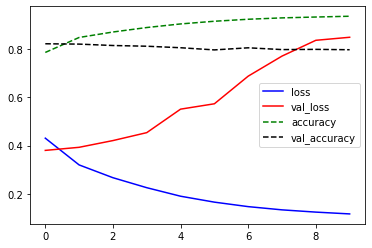

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r-', label = 'val_loss')
plt.plot(history.history['accuracy'], 'g--', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.legend()
plt.show()

- 결과가 조금 아쉽다.
- 일단 val_loss의 증가와 val_accuracy의 감소 추세를 볼 때에 네트워크가 과적합되고 있음을 알 수 있다.
  - 과적합의 이유는 임베딩 레이어를 랜덤한 값부터 학습을 시키기 때문에 각 단어를 나타내는 벡터의 품질이 좋지 않기 때문이다.
  - 때문에 이를 개선하기 위해서는 임베딩 레이어를 별도로 학습 시켜서 사용하거나 RNN이 아닌 CNN을 사용할 수도 있다.

In [22]:
test_x = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t')>0]
test_x = [clean_str(i) for i in test_x]
sentence = [i.split(' ') for i in test_x]
new = []
for i in sentence:
  new.append([word[:5] for word in i][:25])
sentence = new
test_x = tokenizer.texts_to_sequences(sentence)
test_x = pad_sequences(test_x, padding = 'post')
model.evaluate(test_x, test_y, verbose = 0)


[0.8695496916770935, 0.7935199737548828]

- 정확도는 약 78.96%가 나왔다.

In [27]:
test_sentence = '기뻐서 보러 갔는데 배우들의 연기와 내용에 너무 실망했고 지루하기까지 했다.'
test_sentence = test_sentence.split(' ')
test = []
now_test = []
for i in test_sentence:
  now_test.append(i)
  test.append(now_test[:])
#tokenizer.fit_on_texts(now_test)
new_x = tokenizer.texts_to_sequences(test)
new_x = pad_sequences(new_x, padding='post', maxlen=25)
pred = model.predict(new_x)

- 원래대로라면 tokenizer에 문장이 담긴 리스트를 fit_on_text를 실행해서 위에서 test 리스트에 데이터를 넣은 것처럼 학습을 위한 준비를 마쳐야 하는데 이번에는 그냥 직접 넣어주었다.(경과를 마지막에 살피기 위해서)

In [28]:
pred = np.array(pred)

In [29]:
pred[0][0]

0.5531762

In [30]:
for i, j in enumerate(test):
  print(j)
  a,b = pred[i][0], pred[i][1]
  if a > b:print('Negative')
  else:print('Positive')
  print(pred[i])

['기뻐서']
Negative
[0.5531762  0.44682375]
['기뻐서', '보러']
Positive
[0.49398127 0.50601876]
['기뻐서', '보러', '갔는데']
Positive
[0.2973005 0.7026995]
['기뻐서', '보러', '갔는데', '배우들의']
Negative
[0.51674694 0.4832531 ]
['기뻐서', '보러', '갔는데', '배우들의', '연기와']
Positive
[0.11777214 0.88222784]
['기뻐서', '보러', '갔는데', '배우들의', '연기와', '내용에']
Negative
[0.97394377 0.02605624]
['기뻐서', '보러', '갔는데', '배우들의', '연기와', '내용에', '너무']
Negative
[0.9966898  0.00331018]
['기뻐서', '보러', '갔는데', '배우들의', '연기와', '내용에', '너무', '실망했고']
Negative
[0.9966898  0.00331018]
['기뻐서', '보러', '갔는데', '배우들의', '연기와', '내용에', '너무', '실망했고', '지루하기까지']
Negative
[0.9966898  0.00331018]
['기뻐서', '보러', '갔는데', '배우들의', '연기와', '내용에', '너무', '실망했고', '지루하기까지', '했다.']
Negative
[0.9966898  0.00331018]


- 처음에는 긍정으로 분석하다가 나중에는 부정으로 최종 결론이 나도록 확률이 예측이 된 상태를 볼 수 있다.
- 처음에는 정확도가 56%남짓으로 나왔었는데 그 이유는 앞에서 clean_str()함수에서 구두점이 하나 빠져서 데이터의 정제가 생각만큼 깔끔하게 되지 않았던 것 같다
- 그 부분을 고쳐 주니 Tokenizing한 벡터의 값도 완전히 달라져 있었고, 따라서 데이터 전처리의 중요성을 더 뼈저리게 느낀 것 같다.